In [1]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web
from qiskit_finance.applications.optimization import PortfolioDiversification

In [2]:
%matplotlib inline

In [3]:
# set number of assets (= number of qubits)

seed = 123
assets = ['MSFT', 'AAPL', 'GS', 'DIS', 'MCD', 'WMT']
# assets = ["MSFT", "AAPL"]


import yfinance as yf
import numpy as np
stocks_data = yf.download(assets, start = '2013-01-01', end = '2021-12-31')['Adj Close']
stocks_data.head()
log_return = np.log(stocks_data/stocks_data.shift(1))


trading_days = log_return.shape[0]
num_assets = len(assets)
mu = log_return.mean()*trading_days
sigma = log_return.cov()*trading_days
sigma = np.array(sigma)
mu = np.array(mu)

# # Using data from yahoo finance
# # use the name listed for particular company that you wish to add

# data = YahooDataProvider(
#         tickers= assets , 
#         start=datetime.datetime(2011, 1, 1),
#         end=datetime.datetime(2015, 12, 31),
#     )

# num_assets = len(assets)
# data.run()

# mu = data.get_period_return_mean_vector()
# sigma = data.get_period_return_covariance_matrix()
# rho = data.get_similarity_matrix()
# # print(rho)

[*********************100%***********************]  6 of 6 completed


### difference between percent_return n log_returns

In [4]:
percetn_return = stocks_data.pct_change()
percetn_return.head()

,AAPL,DIS,GS,MCD,MSFT,WMT
Date,,,,,,
2012-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0.031682,0.026311,0.032142,0.021653,0.034070,0.014803
2013-01-03,-0.012622,0.002153,-0.005468,0.005659,-0.013396,-0.006354
2013-01-04,-0.027855,0.019137,0.027264,-0.008607,-0.018716,0.003779
2013-01-07,-0.005882,-0.023376,-0.001859,0.011798,-0.001870,-0.009557


In [5]:
log_return.head()

,AAPL,DIS,GS,MCD,MSFT,WMT
Date,,,,,,
2012-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0.031190,0.025970,0.031636,0.021422,0.033502,0.014694
2013-01-03,-0.012702,0.002150,-0.005483,0.005643,-0.013486,-0.006375
2013-01-04,-0.028250,0.018956,0.026899,-0.008644,-0.018893,0.003772
2013-01-07,-0.005900,-0.023654,-0.001860,0.011728,-0.001871,-0.009603


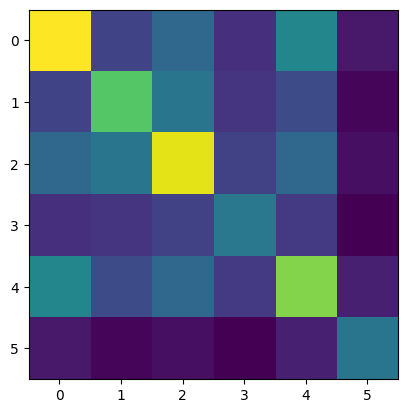

In [6]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [7]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term


portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.36020930086994957*x_0^2 + 0.23633281165609188*x_..., 6 variables, 1 constraints, 'Portfolio optimization'>

In [8]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname, maxiter):
    
    f = open(fname, 'w')
    header = ['ITERATION', 'SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    for j in range(maxiter):
        selection = result.x
        value = result.fval
        print("Optimal: selection {}, value {:.4f}".format(selection, value))

        eigenstate = result.min_eigen_solver_result.eigenstate
        eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
        probabilities = np.abs(eigenvector) ** 2
        i_sorted = reversed(np.argsort(probabilities))
        
        print("\n----------------- Full result ---------------------")
        print("Iteration\tselection\tvalue\t\tprobability")
        print("---------------------------------------------------")
        for i in i_sorted:
            x = index_to_selection(i, num_assets)
            value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
            value = portfolio.to_quadratic_program().objective.evaluate(x)
            probability = probabilities[i]
            row = [j,x, value, probability]
            writer.writerow(row)
            
            print("%10d\t  %10s\t%.4f\t\t%.4f" % (j, x, value, probability))
        
    f.close()

In [9]:
maxiter = 5
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = 'nes1.csv' #change the location and nsame of .csv file

print_result(result,fname, maxiter)

Optimal: selection [1. 0. 0. 1. 1. 0.], value -4.8282

----------------- Full result ---------------------
Iteration	selection	value		probability
---------------------------------------------------
         0	  [1 0 0 1 1 0]	-4.8282		1.0000
         0	  [1 1 1 1 1 1]	-4.8611		0.0000
         0	  [0 1 1 1 1 1]	-4.1303		0.0000
         0	  [1 0 1 1 1 0]	-4.8648		0.0000
         0	  [0 0 1 1 1 0]	-3.7435		0.0000
         0	  [1 1 0 1 1 0]	-5.0927		0.0000
         0	  [0 1 0 1 1 0]	-3.8907		0.0000
         0	  [0 0 0 1 1 0]	-3.3899		0.0000
         0	  [1 1 1 0 1 0]	-4.4440		0.0000
         0	  [0 1 1 0 1 0]	-3.3650		0.0000
         0	  [1 0 1 0 1 0]	-4.3239		0.0000
         0	  [0 0 1 0 1 0]	-3.0086		0.0000
         0	  [1 1 0 0 1 0]	-4.5252		0.0000
         0	  [0 1 0 0 1 0]	-3.1292		0.0000
         0	  [1 0 0 0 1 0]	-4.0557		0.0000
         0	  [0 0 0 0 1 0]	-2.4234		0.0000
         0	  [1 1 1 1 0 0]	-3.5327		0.0000
         0	  [0 1 1 1 0 0]	-2.2560		0.0000
         0	  [1 0 1 1 0 0]	-

In [10]:
# VQE solution
#provide fname ='complete address/location of your .csv file'

from qiskit.utils import algorithm_globals
maxiter=10
for j in range(maxiter):
    algorithm_globals.random_seed = 1234
    backend = Aer.get_backend("statevector_simulator")
    cobyla = COBYLA(maxiter=j)
    ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
    quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
    vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
    vqe = MinimumEigenOptimizer(vqe_mes)
    result = vqe.solve(qp)
fname = 'vqe1.csv' #change the location and name of .csv file1
print_result(result, fname, maxiter)
# print(result)

#0. 0. 1. 1. 1. 0. 1. 1. 1. 1 --numpy exact solver

Optimal: selection [1. 0. 0. 1. 1. 0.], value -4.8282

----------------- Full result ---------------------
Iteration	selection	value		probability
---------------------------------------------------
         0	  [1 0 1 0 1 1]	-4.6399		0.1514
         0	  [0 1 1 1 1 0]	-3.8949		0.1302
         0	  [1 0 0 0 0 1]	-2.6433		0.0902
         0	  [1 1 1 0 1 0]	-4.4440		0.0740
         0	  [1 1 0 1 1 0]	-5.0927		0.0499
         0	  [0 0 1 0 1 0]	-3.0086		0.0464
         0	  [1 0 1 0 0 0]	-2.6083		0.0444
         0	  [0 1 0 0 0 0]	-0.9578		0.0371
         0	  [1 0 0 0 1 1]	-4.5090		0.0349
         0	  [1 0 0 1 1 1]	-5.1686		0.0325
         0	  [0 0 1 0 1 1]	-3.4788		0.0278
         0	  [0 0 1 1 1 1]	-4.1008		0.0232
         0	  [0 1 1 0 0 0]	-1.5096		0.0225
         0	  [0 0 1 1 0 1]	-2.3759		0.0205
         0	  [1 1 0 0 1 0]	-4.5252		0.0201
         0	  [1 0 1 0 1 0]	-4.3239		0.0166
         0	  [1 0 0 1 0 1]	-3.5195		0.0157
         0	  [1 1 0 0 0 0]	-2.7455		0.0134
         0	  [0 1 1 1 1 1]	-

In [11]:
maxiter=50
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")
for j in range(maxiter):
    cobyla = COBYLA(maxiter=j)
    quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
    qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)

fname = 'qaoa1.csv' #change the location and name of .csv file
print_result(result, fname, maxiter)

#0. 0. 1. 1. 1. 0. 1. 1. 1. 1 -numpy exact solver

Optimal: selection [1. 0. 0. 1. 1. 0.], value -4.8282

----------------- Full result ---------------------
Iteration	selection	value		probability
---------------------------------------------------
         0	  [1 0 1 0 1 0]	-4.3239		0.1141
         0	  [1 0 0 0 1 1]	-4.5090		0.1009
         0	  [1 1 0 0 1 0]	-4.5252		0.0829
         0	  [0 0 1 0 1 0]	-3.0086		0.0746
         0	  [0 1 1 0 1 0]	-3.3650		0.0677
         0	  [1 0 0 0 1 0]	-4.0557		0.0638
         0	  [0 0 1 0 1 1]	-3.4788		0.0521
         0	  [0 0 0 0 1 0]	-2.4234		0.0505
         0	  [1 0 1 0 1 1]	-4.6399		0.0420
         0	  [1 1 1 0 1 0]	-4.4440		0.0349
         0	  [0 1 0 0 1 1]	-3.6149		0.0323
         0	  [1 1 0 0 1 1]	-4.8566		0.0316
         0	  [0 1 0 0 1 0]	-3.1292		0.0287
         0	  [0 1 1 0 1 1]	-3.7133		0.0200
         0	  [1 0 0 1 1 0]	-4.8282		0.0198
         0	  [0 0 0 0 1 1]	-3.0309		0.0190
         0	  [1 0 0 0 0 0]	-2.0240		0.0188
         0	  [0 0 0 1 1 1]	-3.8845		0.0123
         0	  [0 0 1 1 1 1]	-

In [13]:
selected_assets = [1, 0, 0, 1, 1, 0] #, 0, 0, 1, 1, 1, 1]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['MSFT', 'DIS', 'MCD']


In [15]:
log_return = log_return[my_assets]
log_return.head()

,MSFT,DIS,MCD
Date,,,
2012-12-31,NaN,NaN,NaN
2013-01-02,0.033502,0.025970,0.021422
2013-01-03,-0.013486,0.002150,0.005643
2013-01-04,-0.018893,0.018956,-0.008644
2013-01-07,-0.001871,-0.023654,0.011728


In [90]:
import numpy as np
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.80641839 0.1737445  0.01983711]


In [91]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * trading_days
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*trading_days,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [92]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [93]:
# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets))) 
init_guess = np.random.dirichlet(np.ones(len(my_assets)),size=1)

In [94]:
neg_sharpe(weights)

-3.485319765302419

In [95]:
# from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

/tmp/ipykernel_14271/1283317279.py:2: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)


In [96]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [97]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [98]:
weights_alloc = dict(zip(my_assets, weights))
weights_alloc

{'MSFT': 0.8064183859894501,
 'DIS': 0.17374450235944916,
 'MCD': 0.01983711165110083}

In [99]:
my_assets

['MSFT', 'DIS', 'MCD']

In [100]:
# my_weights = np.array(my_assets)
my_weights

[0.7421410926279068, 2.6020852139652106e-18, 0.2578589073720932]

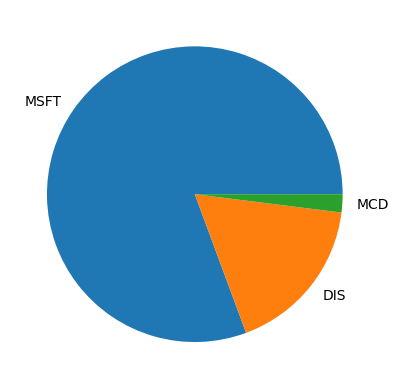

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

### difference in annual returns vs daily_returns*number of days in dataframe

In [103]:
# daily_returns*number of days in dataframe
ret = np.sum(log_return.mean() * my_weights) * trading_days
vol = np.sqrt(np.dot(np.array(my_weights).T,np.dot(log_return.cov()*trading_days,my_weights)))
sr = ret/vol 

risk_ret_dict = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sr 
}

risk_ret_dict

{'returns': 237.44741547942425,
 'risk': 66.37949123893671,
 'sharpe_ratio': 3.5771201473165704}

In [104]:
#annual returns

ret = np.sum(log_return.mean() * my_weights) * 252
vol = np.sqrt(np.dot(np.array(my_weights).T,np.dot(log_return.cov()*252,my_weights)))
sr = ret/vol 

risk_ret_dict = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sr 
}

risk_ret_dict

{'returns': 26.394684032119503,
 'risk': 22.131376668872306,
 'sharpe_ratio': 1.1926363383098315}